# Initialization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
from tqdm import tqdm
import joblib

In [2]:
import qgrid
qgrid.enable()
qgrid.set_grid_option('forceFitColumns',False)

In [3]:
# Read in training dataset
HMAHCC_COMP = pd.read_csv('HMAHCC_COMP.csv',low_memory=False,na_values='NULL')

In [4]:
# Read in data dictionary
HMAHCC_DataDictionary = pd.read_excel('HMAHCC_DataDictionary.xlsx','Event Attributes')

# Preprocess Attributes

In [3]:
def preprocess_attr(row):
    '''
    Proprocess the HMAHCC data to make it have correct attribute names
    
    :param row: a row from data dictionary file
    :return: subset of HMAHCC data with the same event_descr in row
    '''
    # Get event description of the row
    event_description = row["Event Description"]
    # Filter the HMAHCC data to the event description in row
    COMP_filtered = HMAHCC_COMP.query('event_descr == @event_description')
    # Select all columns has 'event_attr' in column names
    COMP_attr = COMP_filtered.filter(like='event_attr')
    # Rename thoese event_attr columns with the attribute names in row
    COMP_attr.columns = row.filter(like='Attribute')
    # From attr columns, select columns whose names are not null(not attribute in dictionary)
    COMP_attr_not_null = COMP_attr.loc[:, COMP_attr.columns.notnull()]
    # Get the the rest of the columns other than attr
    COMP_rest = COMP_filtered.iloc[:,~COMP_filtered.columns.str.contains('event_attr')]
    # Combine non-attr and attr columns together
    COMP = pd.concat([COMP_rest,COMP_attr_not_null],axis=1)
    return COMP

In [6]:
# Apply preprocess_attr to each row in data dictionary
results = [preprocess_attr(row) for n,row in tqdm(HMAHCC_DataDictionary.iterrows())]

16it [00:06,  2.61it/s]


In [7]:
# Concat processed HMAHCC data with different event_descr together
HMAHCC_COMP_processed = pd.concat(results, axis=0, ignore_index=True,sort=False)\
    .astype({'Member Responsible Amount': 'float'})

In [8]:
# Replace space in the column names with _
HMAHCC_COMP_processed.columns = HMAHCC_COMP_processed.columns.str.replace(' ', '_')

# LTOT Identification

## Filtering

In [9]:
# Find all rejected and reversal rx, group by unique identifiers of an rx, count reversal times
reversal = HMAHCC_COMP_processed\
    .query("event_descr=='RX Claim - Rejected'")\
    .query('Status_Code=="REVERSAL"')\
    .groupby(['id','Days','Brand_Name','Generic_Name','Member_Responsible_Amount'])\
    .size().to_frame('reversal_times')

In [10]:
# Join reversal rx to paid scripts, find the paid scripts that get rejected, also count times the patient paid
# This is for avoiding the situation the first paid script get rejected, but the second one goes through
# reversal_multiplier == 1 would be the paid scripts that get rejected
paid_reversal = HMAHCC_COMP_processed\
    .query("event_descr=='RX Claim - Paid'")\
    .merge(reversal,on=['id','Days','Brand_Name','Generic_Name','Member_Responsible_Amount'],
           how='inner',suffixes=['','_right'])\
    .groupby(['id','event_descr','Days','Brand_Name','Generic_Name','Member_Responsible_Amount','reversal_times'])\
    .size().to_frame('paid_times').reset_index()\
    .assign(actual_times=lambda df:df.paid_times - df.reversal_times)\
    .assign(reversal_multiplier=lambda df:df.actual_times/df.paid_times)\
    .assign(reversal_multiplier=lambda df: np.where(df.reversal_multiplier<0,0,df.reversal_multiplier))\
    .drop(columns=['reversal_times','actual_times','paid_times','actual_times'])

In [11]:
# Join reversal adjustment to HMAHCC data
HMAHCC_COMP_processed_reversed = HMAHCC_COMP_processed\
    .merge(paid_reversal,
           on=['id','event_descr','Days','Brand_Name','Generic_Name','Member_Responsible_Amount'],
           how='left')

In [12]:
# Save the data to parquet format
HMAHCC_COMP_processed_reversed.to_parquet('HMAHCC_COMP_processed_reversed.parquet',index=False)

## Identification

In [5]:
# Get all paid scripts that were not rejeceted, have MME and Days >=0, in order to create target variable
HMAHCC_MME = pd.read_parquet('HMAHCC_COMP_processed_reversed.parquet')\
    .query('reversal_multiplier!=0')\
    .query('event_descr == "RX Claim - Paid"')\
    .query('MME.notnull()',engine='python')\
    .query('Days>=0')\
    .assign(PAY_DAY_SUPPLY_CNT=lambda df: df.PAY_DAY_SUPPLY_CNT.astype(int))

In [6]:
def PDC_calc(ID):
    '''
    Identify whether a patient is an LTOT patient
    
    :param ID: ID of a patient
    :return: list of two elements: ID, a flag whether the patient is LTOT
    '''
    # Get all paid records for ID patient
    df = HMAHCC_MME.query(f'id=="{ID}"')
    # For each row in the data, create a range of covered days, turn it into a set of days, then union all the sets
    days_covered = set.union(*df\
        .apply(lambda row: set(range(row.Days,row.Days+row.PAY_DAY_SUPPLY_CNT)),axis=1)\
        .to_list())
    # Check in the set of covered days, count the number of days < 180
    num_days_covered = sum([1 if day <180 else 0 for day in days_covered])
    # If days covered percentage is greater than 90%, then the patient is LTOT
    return [ID, 1] if num_days_covered >= 0.9*180 else [ID, 0]

In [7]:
# For each patietn ID, create LTOT flag
results = [PDC_calc(ID) for ID in tqdm(HMAHCC_MME.id.unique())]

100%|███████████████████████████████████████████████████████████████████████████| 13947/13947 [01:44<00:00, 133.34it/s]


In [8]:
# Concat LTOT flags for each patient
HMAHCC_target = pd.DataFrame(results,columns=['id','LTOT']).set_index('id')

# Feature Engineering

In [9]:
# Read in preprocessed HMAHCC data
HMAHCC = pd.read_parquet('HMAHCC_COMP_processed_reversed.parquet')

In [10]:
# Get state from location column, filter data to Days<=0, remove rejected scripts, fill na in descriptive columns
HMAHCC = HMAHCC\
    .assign(state = lambda df: df.Location.fillna('').str.split(', ').apply(lambda x:x[-1]))\
    .query('Days <= 0')\
    .query('reversal_multiplier!=0')\
    .fillna({'Diagnosis':'','Place_of_Treatment':'','Drug_Group_Description':'',
             'DRUG_TYPE':''})

## Inbound Call by Mbr

### State

In [11]:
# Get state for each patient, for patients who has multiple states, get the one with max count
# state = HMAHCC\
#     .query('event_descr == "Inbound Call by Mbr"')\
#     .groupby(['id','state'])\
#     .size().to_frame('state_count').reset_index()\
#     .set_index('id')\
#     .assign(state_max=lambda df:df.groupby('id').state_count.max())\
#     .query('state_count == state_max')\
#     [['state']].reset_index()\
#     .sort_values(['id','state'],ascending=[True,False])\
#     .drop_duplicates(subset='id')\
#     .set_index('id').pipe(pd.get_dummies)

### Frequency

In [12]:
# Calculate the frequency of inbound call by member
freq_inbound_call_by_mbr = HMAHCC\
    .query('event_descr == "Inbound Call by Mbr"')\
    .groupby('id')\
    .size().to_frame('freq_inbound_call_by_mbr')

### Recency

In [13]:
# Calculate the recency of inbound call by member
rec_inbound_call_by_mbr = HMAHCC\
    .query('event_descr == "Inbound Call by Mbr"')\
    .groupby('id')\
    .Days.max().abs().to_frame('rec_inbound_call_by_mbr')

## Inbound Call by Other

### Frequency

In [14]:
# Calculate the frequency of inbound call by other
freq_inbound_call_by_other = HMAHCC\
    .query('event_descr == "Inbound Call by Other"')\
    .groupby('id')\
    .size().to_frame('freq_inbound_call_by_other')

### Recency

In [15]:
# Calculate the recency of inbound call by other
rec_inbound_call_by_other = HMAHCC\
    .query('event_descr == "Inbound Call by Other"')\
    .groupby('id')\
    .Days.max().abs().to_frame('rec_inbound_call_by_other')

## Inbound Call by Prov

### Frequency

In [16]:
# Calculate the frequency of inbound call by provider
freq_inbound_call_by_prov = HMAHCC\
    .query('event_descr == "Inbound Call by Prov"')\
    .groupby('id')\
    .size().to_frame('freq_inbound_call_by_prov')

### Recency

In [17]:
# Calculate the recency of inbound call by provider
rec_inbound_call_by_prov = HMAHCC\
    .query('event_descr == "Inbound Call by Prov"')\
    .groupby('id')\
    .Days.max().abs().to_frame('rec_inbound_call_by_prov')

## Fully Paid Claim

### Diagnosis Frequency

In [18]:
# Identify top 5 diagnosis from diagnosis column, and the rest assigned to others
fully_paid_claim_diag = HMAHCC\
    .query('event_descr == "Fully Paid Claim"')\
    .assign(diag_hypertension = lambda df:df.Diagnosis.str.contains('HYPERTENSION'))\
    .assign(diag_diabete = lambda df:df.Diagnosis.str.contains('DIABETE'))\
    .assign(diag_CAD = lambda df:df.Diagnosis.str.contains('CORONARY'))\
    .assign(diag_CPD = lambda df:df.Diagnosis.str.contains('PULMONARY'))\
    .assign(diag_CHF = lambda df:df.Diagnosis.str.contains('HEART FAILURE'))\
    .assign(diag_other = lambda df: (~df.diag_hypertension)&(~df.diag_diabete)&
            (~df.diag_CAD)&(~df.diag_CPD)&(~df.diag_CHF))

In [19]:
# Get the frequency of top 5 diagnosis and other
freq_diag_fully_paid_claim = fully_paid_claim_diag\
    .groupby('id')\
    [['diag_hypertension','diag_diabete','diag_CAD','diag_CPD','diag_CHF','diag_other']].sum()\
    .rename(columns=lambda x:'freq_'+x+'_fully_paid_claim')

### Diagnosis Recency

In [20]:
# Get the recency of top 5 diagnosis and other
rec_diag_fully_paid_claim = fully_paid_claim_diag\
    .melt(['id','Days'],['diag_hypertension','diag_diabete','diag_CAD','diag_CPD','diag_CHF','diag_other'],
          'diag')\
    .query('value')\
    .groupby(['id','diag'])\
    .Days.max().abs().unstack().rename(columns=lambda x:'rec_'+x+'_fully_paid_claim')

### Monetary

In [21]:
# Get the average and total money spent for each patient
mon_full_paid_claim = HMAHCC\
    .query('event_descr == "Fully Paid Claim"')\
    .groupby('id')\
    .Member_Responsible_Amount.agg(['mean','sum'])\
    .rename(columns=lambda x:'mon_full_paid_claim_'+x)

## New diagnosis - CAD, Diabetes, Hypertension, CPD, CHF

### Frequency

In [22]:
top5_disease = ['CAD', 'Diabetes', 'Hypertension', 'CPD', 'CHF']

In [23]:
def new_diag_freq(disease):
    '''
    Calculate the frequency of frequency of new diagnosis disease
    
    :param disease: one of top5 disease
    :return: frequency of new diagnosis disease
    '''
    return HMAHCC\
        .query(f'event_descr == "New diagnosis - {disease}"')\
        .groupby('id')\
        .size().to_frame(f'new_diag_{disease}')

In [24]:
# For each of top 5 diseases, get the frequency of new diagnosis disease
results = [new_diag_freq(disease) for disease in tqdm(top5_disease)]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.63it/s]


In [25]:
# Concat new diagnosis frequency for top 5 diseases
freq_new_diag = pd.concat(results, axis=1,sort=False).fillna(0)

### Recency

In [26]:
def new_diag_rec(disease):
    '''
    Calculate the recency of frequency of new diagnosis disease
    
    :param disease: one of top5 disease
    :return: recency of new diagnosis disease
    '''
    return HMAHCC\
        .query(f'event_descr == "New diagnosis - {disease}"')\
        .groupby('id')\
        .Days.max().abs().to_frame(f'rec_new_diag_{disease}')

In [27]:
# For each of top 5 diseases, get the recency of new diagnosis disease
results = [new_diag_rec(disease) for disease in tqdm(top5_disease)]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.49it/s]


In [28]:
# Concat new diagnosis recency for top 5 diseases
rec_new_diag = pd.concat(results, axis=1,sort=False)

## Surgery

### Frequency surgery diagnosis

In [29]:
# Get all the words from diagnosis column, count the term frequency of each word
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(stop_words='english')
tdm = vec.fit_transform(HMAHCC.query('event_descr == "Surgery"').Diagnosis)
term_frequency = pd.Series(np.array(tdm.sum(axis=0)).reshape(-1),vec.get_feature_names())

In [30]:
# Manually select top 100 disease or human organs that may related to LTOT
top_surgery = ["malignant","neoplasm","colon","cataract","chronic","screening","lumbar",
               "eye","radiculopathy","coronary","pain","spondylosis","lumbosacral",
               "myelopathy","ulcer","artery","benign","neoplasms","breast","initial","heart",
               "atherosclerosis","angina","skin","history","pectoris","foot","intervertebral",
               "knee","atherosclerotic","sclerosis","hernia","gangrene","primary","stenosis",
               "hemorrhage","polyps","colonic","bleeding","female","kidney","leg",
               "unilateral","gastritis","cholecystitis","cervical","diabetes","prostate",
               "esophageal","acute","disorders","limb","shoulder","venous","fracture",
               "urinary","spinal","mellitus","pressure","gallbladder","neuritis","secondary",
               "osteoarthritis","radiculitis","thoracic","inguinal","recurrent","carcinoma",
               "tear","arteries","bladder","carpal","dysphagia","esophagus","reflux","hip",
               "chest","meniscus","esophagitis","senile","ankle","anemia","polyp","wound",
               "rectum","cardiac","claudication","ureter","atrial","renal","sacroiliitis",
               "gastro","fibrillation","hypertension","vascular","lung","osteomyelitis",
               "intestine","anus","rupture"]

In [31]:
# Get the index of each top 100 words in the term document matrix
word_index = [vec.get_feature_names().index(word) for word in top_surgery]

In [32]:
# Calculate the frequency of top 100 words
freq_surgery_diag = pd.DataFrame(tdm[:,word_index].todense(),columns=top_surgery)\
    .rename(columns=lambda x: 'freq_surgery_diag_'+x)\
    .set_index(HMAHCC.query('event_descr == "Surgery"').id)\
    .groupby('id')\
    .sum()

### Frequency place of treatment

In [33]:
# Calculate the frequency of place of treatment for surgery
freq_surgery_place = HMAHCC\
    .query('event_descr == "Surgery"')\
    .groupby(['id','Place_of_Treatment'])\
    .size().unstack(fill_value=0)\
    .rename(columns=lambda x:'freq_surgery_place_'+x)

### Recency place of treatment

In [34]:
# Calculate the recency of place of treatment for surgery
rec_surgery_place = HMAHCC\
    .query('event_descr == "Surgery"')\
    .groupby(['id','Place_of_Treatment'])\
    .Days.max().abs().unstack().rename(columns=lambda x:'rec_surgery_place_'+x)

## New provider

### Frequency

In [35]:
# Calculate the frequency of new provider
freq_new_provider = HMAHCC\
    .query('event_descr == "New provider"')\
    .groupby(['id'])\
    .size().to_frame('freq_new_provider')

### Recency

In [36]:
# Calculate the recency of new provider
rec_new_provider = HMAHCC\
    .query('event_descr == "New provider"')\
    .groupby(['id'])\
    .Days.max().abs().to_frame('rec_new_provider')

## RX Claim - Paid

### Frequency

In [37]:
# Calculate the frequency of each drug each patient uses
freq_rx_claim_paid = HMAHCC\
    .query('event_descr == "RX Claim - Paid"')\
    .groupby(['id','Drug_Group_Description'])\
    .size().unstack(fill_value=0)\
    .rename(columns=lambda x:'freq_paid_'+x)

### Recency

In [38]:
# Calculate the recency of each drug each patient uses
rec_rx_claim_paid = HMAHCC\
    .query('event_descr == "RX Claim - Paid"')\
    .groupby(['id','Drug_Group_Description'])\
    .Days.max().abs().unstack()\
    .rename(columns=lambda x:'rec_paid_'+x)

### Monetary

In [39]:
# Calculate the average and total money each patient spends on each drug
mon_rx_claim_paid = HMAHCC\
    .query('event_descr == "RX Claim - Paid"')\
    .groupby('id')\
    .Member_Responsible_Amount.agg(['mean','sum'])\
    .rename(columns=lambda x:'mon_paid_'+x)

### PAY_DAY_SUPPLY_CNT

In [40]:
# Calculate the average and total days supply each patient has on each drug
pay_day_supply_cnt = HMAHCC\
    .query('event_descr == "RX Claim - Paid"')\
    .groupby('id')\
    .PAY_DAY_SUPPLY_CNT.agg(['mean','sum'])\
    .rename(columns=lambda x:x+'_pay_day_supply_cnt')

### MME

#### Mean & Sum

In [88]:
# Calculate the average and total MME each patient has on each drug
MME = HMAHCC\
    .query('event_descr == "RX Claim - Paid"')\
    .assign(MME_per_rx=lambda df:df.MME*df.PAY_DAY_SUPPLY_CNT)\
    .groupby('id')\
    .MME_per_rx.agg(['mean','sum'])\
    .rename(columns=lambda x:x+'_MME_per_rx')

#### Frequency

In [89]:
# Calculate the frequency of MME drug each patient uses
freq_MME = HMAHCC\
    .query('event_descr == "RX Claim - Paid"')\
    .query('MME.notnull()',engine='python')\
    .groupby('id')\
    .size()\
    .to_frame('freq_MME')

#### Recency

In [90]:
# Calculate the recency of MME drug each patient uses
rec_MME = HMAHCC\
    .query('event_descr == "RX Claim - Paid"')\
    .query('MME.notnull()',engine='python')\
    .query('Days<0')\
    .groupby('id')\
    .Days.max().abs()\
    .to_frame('rec_MME')

### DRUG_TYPE

In [43]:
# Calculate the frequency of each drug type for each patient
drug_type = HMAHCC\
    .query('event_descr == "RX Claim - Paid"')\
    .groupby(['id','DRUG_TYPE'])\
    .size().unstack(fill_value=0)\
    .rename(columns=lambda x:'freq_drug_type_'+x)

### Specialty

In [44]:
# Calculate the frequency of each specialty for each patient
specialty = HMAHCC\
    .query('event_descr == "RX Claim - Paid"')\
    .groupby(['id','Specialty'])\
    .size().unstack(fill_value=0)\
    .rename(columns=lambda x:'freq_specialty_'+x)

## RX Claim - New Drug

### Frequency

In [45]:
# Calculate the frequency of each new drug each patient uses
freq_rx_claim_new_drug = HMAHCC\
    .query('event_descr == "RX Claim - New Drug"')\
    .groupby(['id','Drug_Group_Description'])\
    .size().unstack(fill_value=0)\
    .rename(columns=lambda x:'freq_new_'+x)

### Recency

In [46]:
# Calculate the recency of each new drug each patient uses
rec_rx_claim_new_drug = HMAHCC\
    .query('event_descr == "RX Claim - New Drug"')\
    .groupby(['id','Drug_Group_Description'])\
    .Days.max().abs().unstack()\
    .rename(columns=lambda x:'rec_new_'+x)

## RX Claim - First Time Mail Order

### Frequency

In [47]:
# Calculate the frequency of each mail order drug each patient uses
freq_rx_claim_mail = HMAHCC\
    .query('event_descr == "RX Claim - First Time Mail Order"')\
    .groupby(['id','Drug_Group_Description'])\
    .size().unstack(fill_value=0)\
    .rename(columns=lambda x:'freq_mail_'+x)

### Recency

In [48]:
# Calculate the recency of each mail order drug each patient uses
rec_rx_claim_mail = HMAHCC\
    .query('event_descr == "RX Claim - First Time Mail Order"')\
    .groupby(['id','Drug_Group_Description'])\
    .Days.max().abs().unstack()\
    .rename(columns=lambda x:'rec_mail_'+x)

## Combine Features and Target

In [91]:
# Calculate # of negative days for each of patient
nbr_negative_days = HMAHCC.groupby('id').Days.min().abs().to_frame('nbr_negative_days')

In [92]:
# Put all the features in a list
feature_list = [freq_inbound_call_by_mbr,rec_inbound_call_by_mbr,freq_inbound_call_by_other,
 rec_inbound_call_by_other,freq_inbound_call_by_prov,rec_inbound_call_by_prov,freq_diag_fully_paid_claim,
 rec_diag_fully_paid_claim,mon_full_paid_claim,freq_new_diag,rec_new_diag,freq_surgery_diag,
 freq_surgery_place,rec_surgery_place,freq_new_provider,rec_new_provider,freq_rx_claim_paid,
 rec_rx_claim_paid,mon_rx_claim_paid,pay_day_supply_cnt,MME,freq_MME,rec_MME,drug_type,specialty,
 freq_rx_claim_new_drug,rec_rx_claim_new_drug,freq_rx_claim_mail,rec_rx_claim_mail]

In [93]:
# Concat all features into one dataframe
features = pd.concat(feature_list,axis=1,sort=False)

In [94]:
# Join features with target variable, and join with # of negative days
design_matrix = pd.merge(features,HMAHCC_target,how='inner',left_index=True,right_index=True)\
    .merge(nbr_negative_days,how='inner',left_index=True,right_index=True)

In [95]:
# Normalize frequency by number of days
design_matrix.loc[:,design_matrix.columns.str.contains('freq_')] = design_matrix.loc[:,design_matrix.columns.str.contains('freq_')]\
    .apply(lambda col:col/design_matrix.nbr_negative_days)
design_matrix.drop(columns=['nbr_negative_days'],inplace=True)

In [96]:
design_matrix.shape

(13935, 482)

In [97]:
# Save design matrix to parquet
design_matrix.to_parquet('design_matrix.parquet')

# Modeling

In [5]:
# Read in design matrix
design_matrix = pd.read_parquet('design_matrix.parquet')

In [6]:
# Create features and target dataframe
X = design_matrix.drop(columns='LTOT')
y = design_matrix['LTOT']

In [7]:
# Split training and validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [8]:
# Hyperparameter tuning grid
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [9]:
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
# Initialize XGBoost model, use growth tree algorithm similar to lightgbm
bst = XGBClassifier(n_jobs=-1,grow_policy='lossguide',tree_method ='hist',n_estimators=150)
# Gridsearch on parameter grid, use AUC to determine the best model
cv = GridSearchCV(bst,params,'roc_auc',-1, verbose=10)
# Fit model on the training data, track logloss on training and testing set
cv.fit(X_train, y_train,eval_metric='logloss',eval_set=[(X_train,y_train),(X_test,y_test)],verbose=False)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 405 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     grow_policy='lossguide', learning_rate=0.1,
                                     max_delta_step=0, max_depth=3,
                                     min_child_weight=1, missing=None,
                                     n_estimators=150, n_jobs=-1, nthread=None,
                                     objective='binary:logistic',
                                     ra...g_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, tree_method='hist',
                                     verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
        

In [10]:
# Print out the best parameters
cv.best_params_

{'colsample_bytree': 0.6,
 'gamma': 1,
 'max_depth': 4,
 'min_child_weight': 5,
 'subsample': 1.0}

In [11]:
#save model
joblib.dump(cv.best_estimator_, 'xgb.model') 

['xgb.model']

In [12]:
#load saved model
xgb = joblib.load('xgb.model')

In [13]:
# Predict probability of test set
y_pred = xgb.predict_proba(X_test)

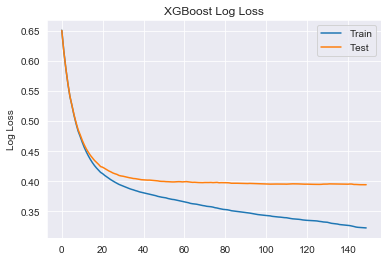

In [14]:
# retrieve performance metrics
results = xgb.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss');

In [15]:
# Calculate AUC
from sklearn import metrics
metrics.roc_auc_score(y_test,y_pred[:,1])

0.8886649966761208

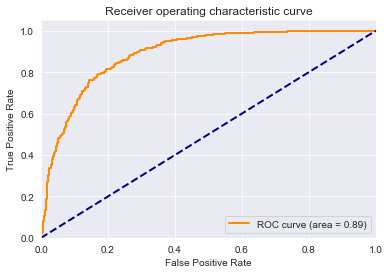

In [16]:
# ROC curve
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred[:,1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc='lower right')
plt.show()

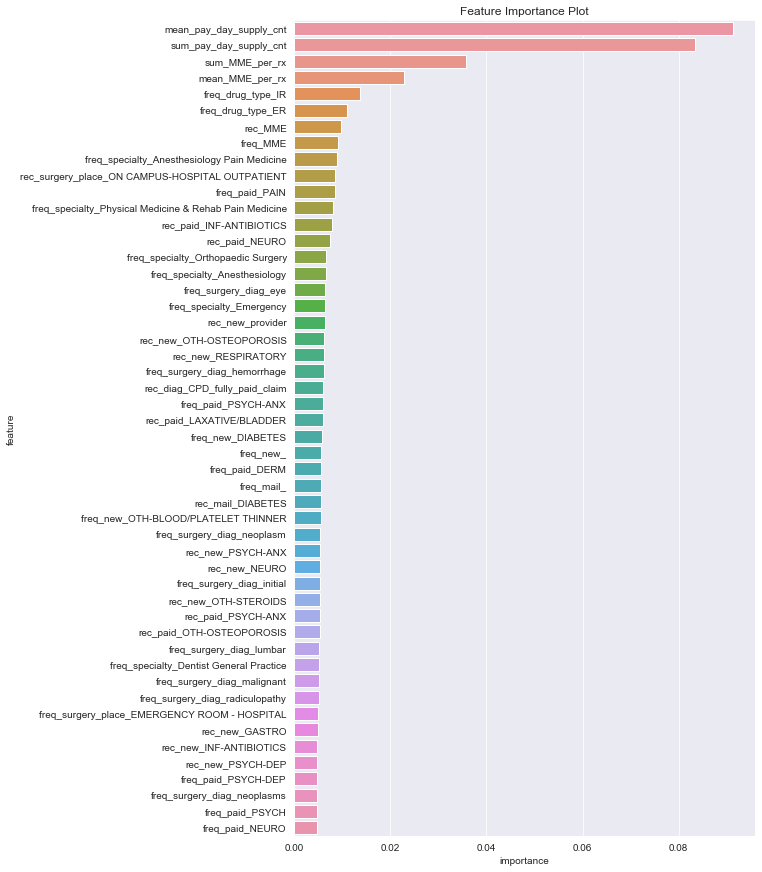

In [17]:
# Feature importance plot
feature_importance = pd.DataFrame({'feature':xgb.get_booster().feature_names, 'importance':xgb.feature_importances_}).sort_values('importance',ascending=False).reset_index().drop(columns='index')
fig, ax = plt.subplots()
fig.set_size_inches(8.27,15)
plt.title('Feature Importance Plot')
sns.barplot(x='importance',y='feature',ax=ax,data=feature_importance[:50])

In [18]:
# Create SHAP tree explainer
import shap
shap.initjs()
explainer = shap.TreeExplainer(xgb.get_booster())

In [19]:
# Create SHAP interaction values from 2000 samples from design matrix
design_matrix_sample = design_matrix.sample(2000,random_state=42)[xgb.get_booster().feature_names]
shap_interaction_values = explainer.shap_interaction_values(design_matrix_sample)

C:\Anaconda3\lib\site-packages\shap\plots\dependence.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = pl.figure(figsize=figsize)


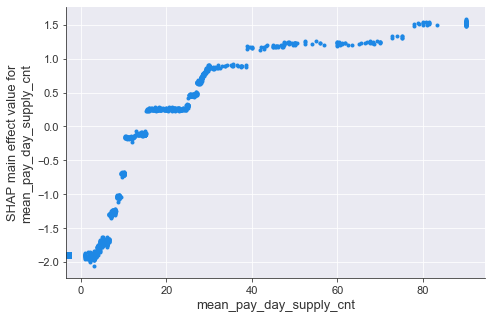

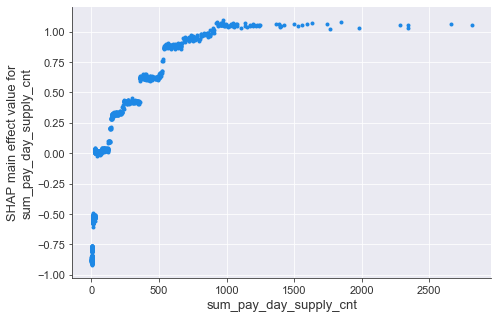

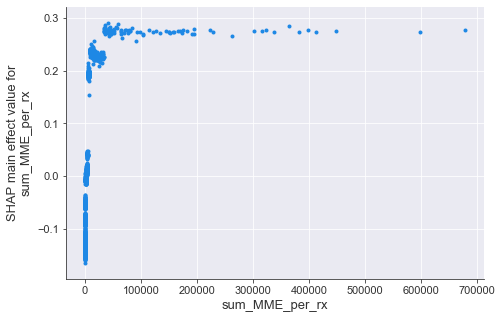

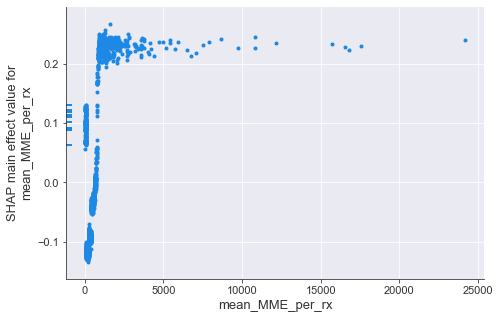

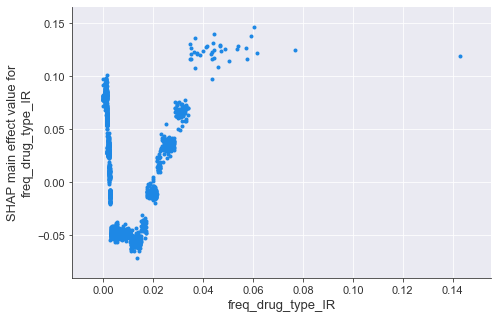

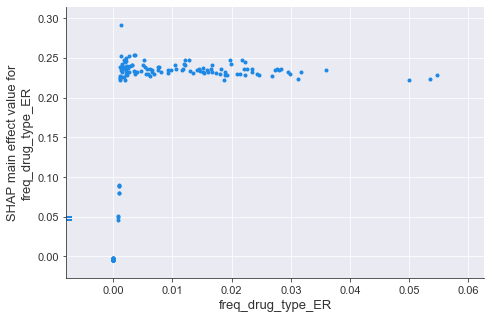

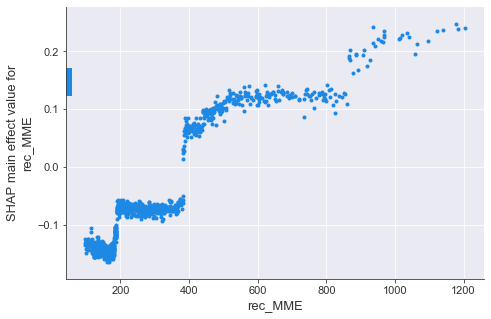

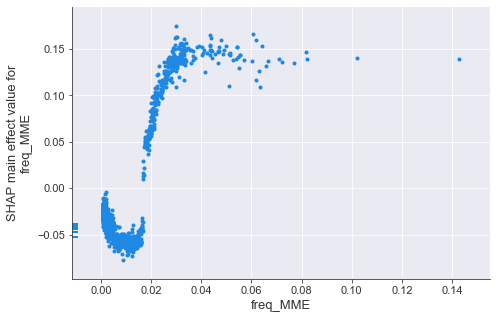

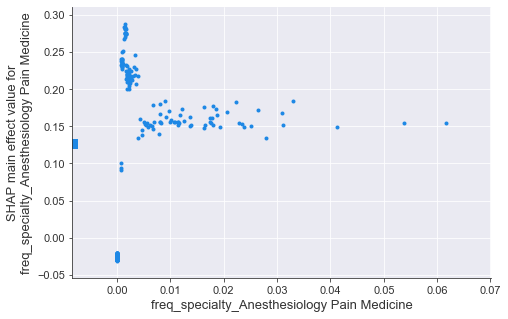

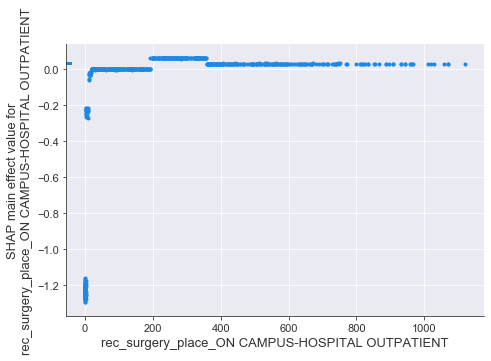

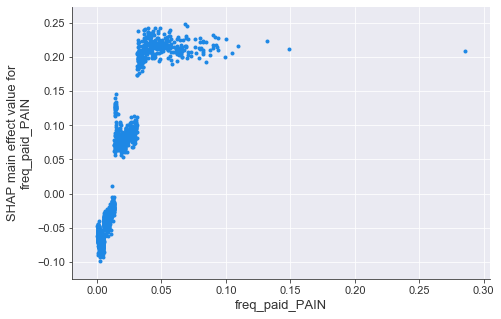

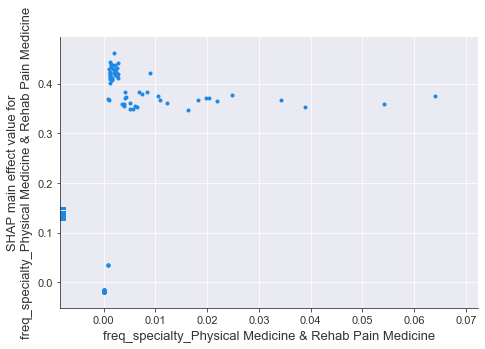

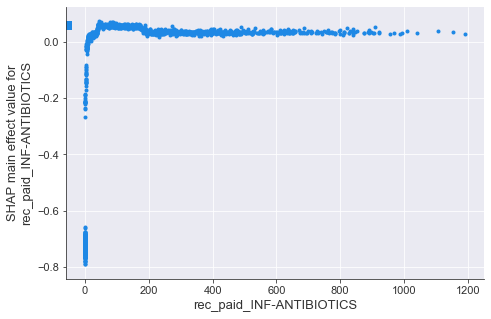

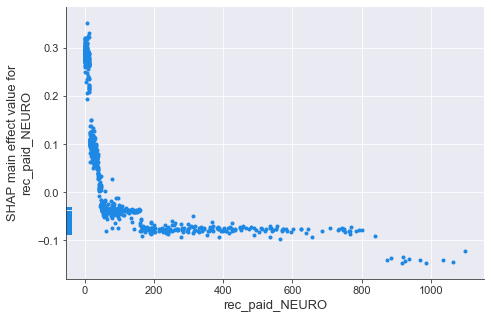

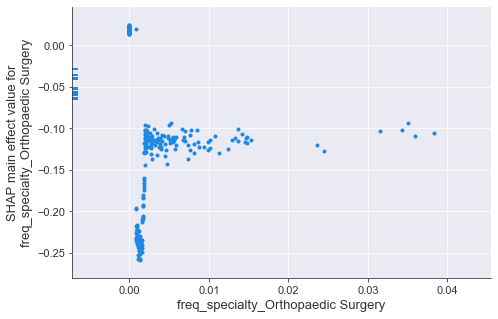

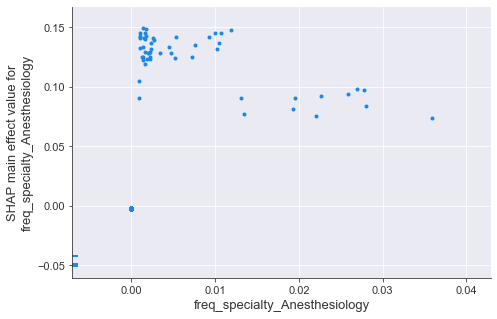

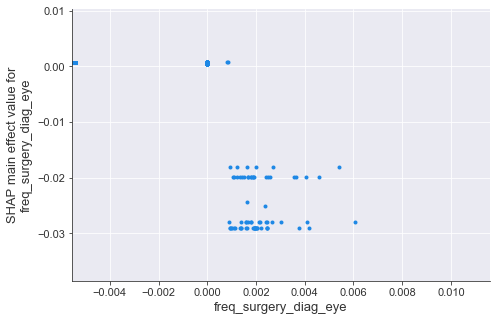

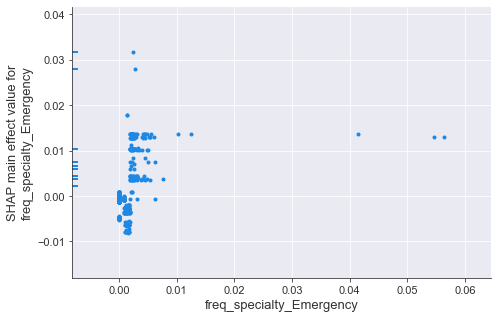

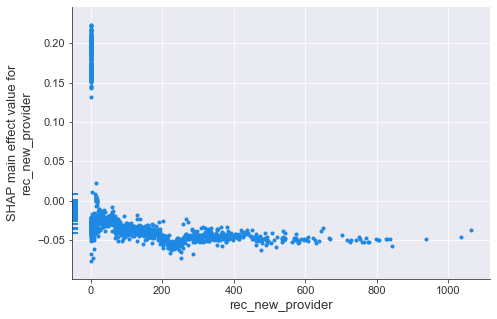

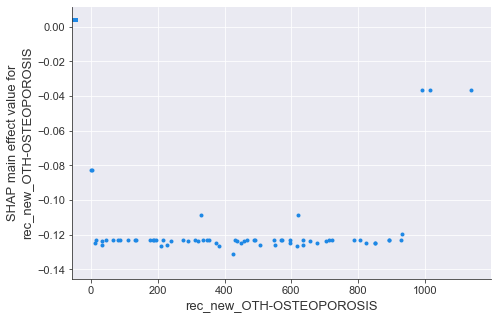

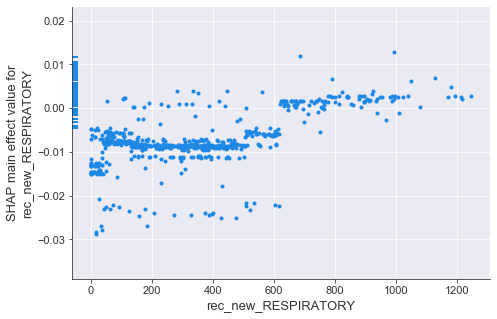

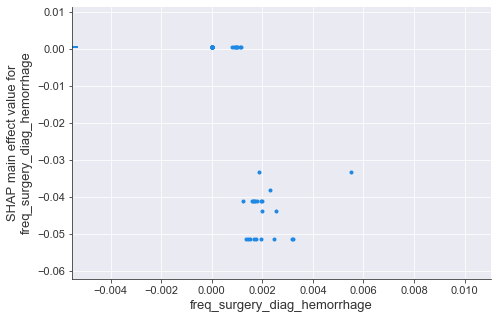

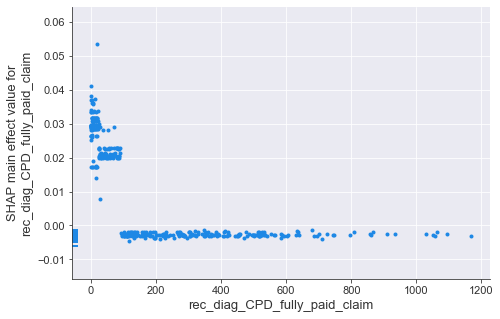

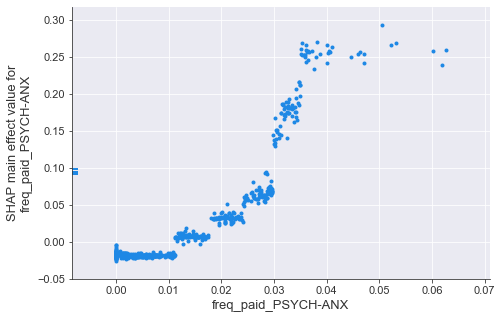

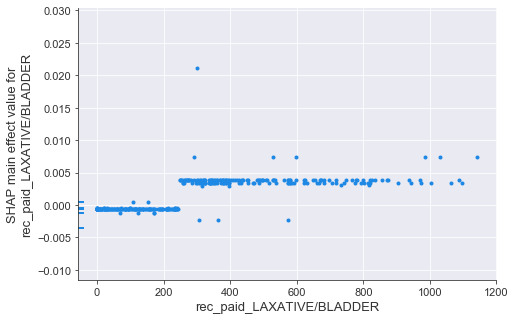

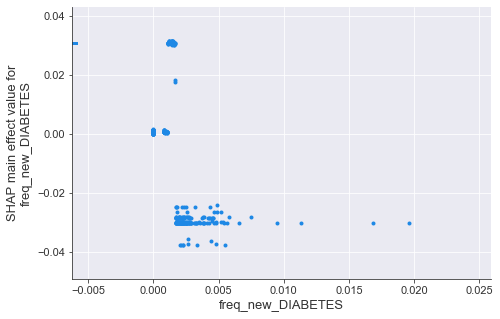

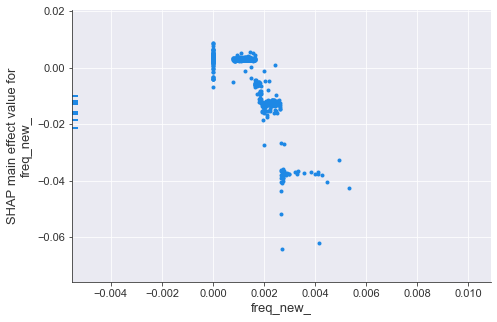

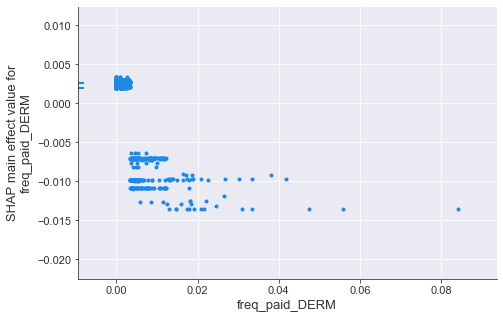

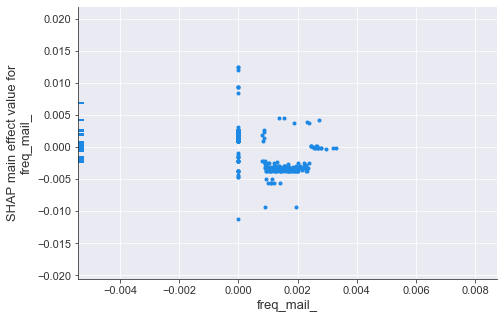

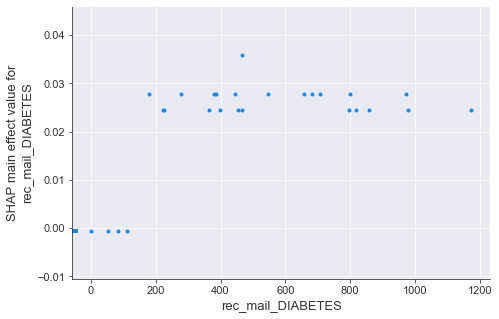

In [20]:
# Plot SHAP dependence plot for top 30 features
for feature in feature_importance.head(30).feature.to_list():
    shap.dependence_plot(
     (feature, feature),
     shap_interaction_values, design_matrix_sample,interaction_index=None,show=False)